# Lending Club Data Loan Default Prediction

In [3]:
library(dplyr)

library(lubridate)
library(ggplot2)
library(dplyr)
library(stringr)
library(caret)
library(rpart)
#library(rattle)
library(ROSE)
library(ROCR)
library(MASS)
library(ipred)
library(plyr)
library(rpart.plot)
require(gridExtra) # also loads grid

library(data.table)
options(datatable.print.nrows = 500)
options(width = 110)
options(repr.plot.width=11, repr.plot.height=5)

In [4]:
# Set working path:
wkdir = "/Users/qiaolinchen/Documents/LendingClub/"
raw_data_path = paste0(wkdir, 'raw_data/')

## 1.Load data from CSV files

In [8]:
#loans = read.csv( paste0(wkdir ,'loan_2016-2017.csv') )

loans = read.csv( paste0(wkdir ,'loan_2014-2017_50K.csv') )

In [9]:
dim(loans)

[1] 50000   124

In [10]:
df = data.frame(loans)

list_1617_only = c( 'revol_util','open_acc_6m','open_act_il','open_il_12m','open_il_24m',
            'open_rv_12m','open_rv_24m', 'total_bal_il','max_bal_bc','all_util','inq_fi','inq_last_12m','total_cu_tl',
                  'mths_since_rcnt_il', 'il_util')

drop_list = c('X','zip3d', 'id', 'url', 'zip_code','city','zipcode','emp_title' )


df = df[, !names(df) %in% c(list_1617_only,drop_list)  ]
dim(df)

[1] 50000   101

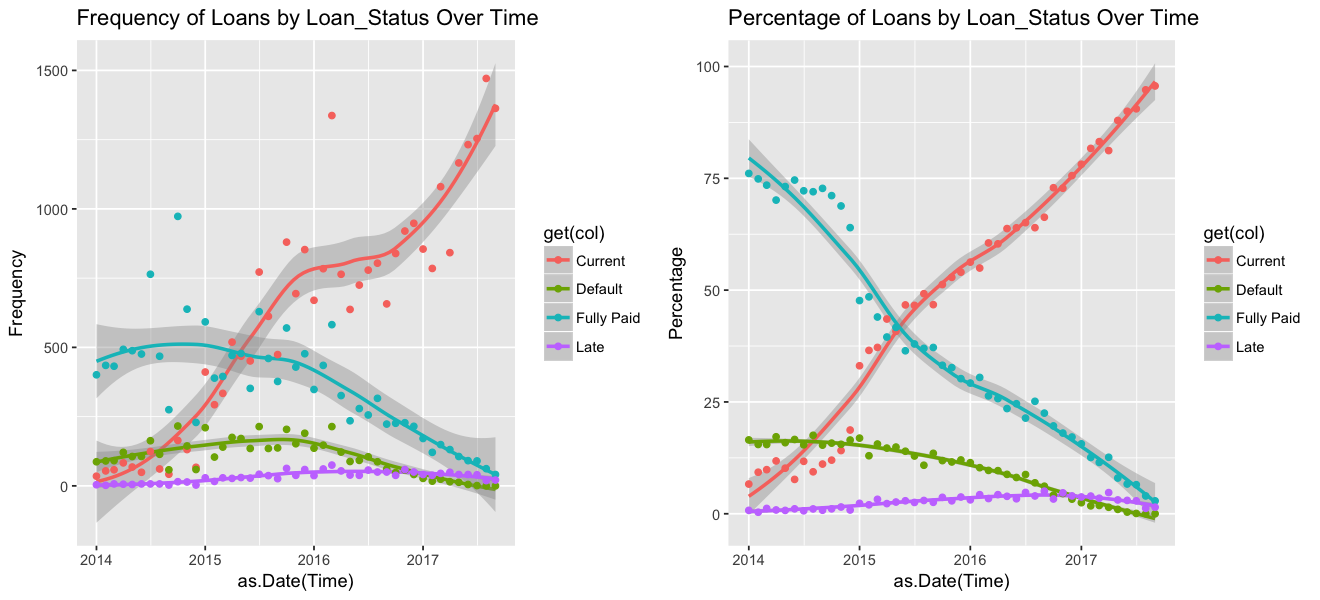

In [11]:
plot_over_time = function(df = df, col ='Loan_Status'){
    options(repr.plot.width=11, repr.plot.height=5)
    count = table( df$issue_d, df[,col]  )
    counts = melt( count ) 
    colnames(counts) = c('Time', col ,'Frequency')

    pct = melt( round( count/ apply( count,1,sum) *100 ,digits= 2) )
    colnames(pct) = c('Time', col ,'Percentage')

    p1 = ggplot(data= counts, aes(x= as.Date(Time), y= Frequency, group= get(col) , colour= get(col) )) +
        geom_smooth(method = 'loess') + geom_point() +ggtitle(paste0('Frequency of Loans by ', col,' Over Time') )
    p2 = ggplot(data= pct, aes(x= as.Date(Time), y= Percentage, group= get(col) , colour= get(col) )) +
        geom_smooth(method = 'loess') + geom_point() +ggtitle(paste0('Percentage of Loans by ', col,' Over Time') )
    grid.arrange(p1, p2, ncol=2)
}
plot_over_time(df=df,  col= 'Loan_Status')

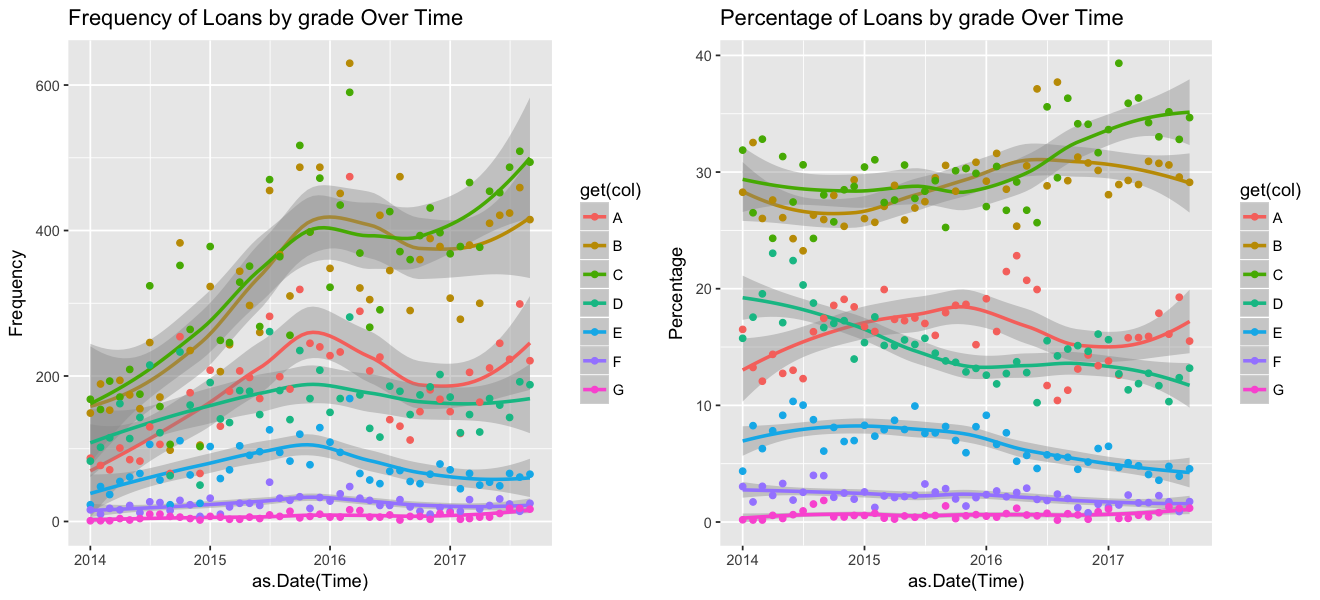

In [12]:
plot_over_time(df=df,  col= 'grade')

In [13]:
# check missingness of columns removed
missing_pct <- function(df, type= 'pct'){
    na_count <-sapply(df, function(y) sum(length(which(is.na(y)))))
    na_count = na_count[na_count>0]
    if (type=='pct'){round( na_count/dim(df)[1] *100, digits=3)}
    else {na_count}
}                      

missing_pct(df)

dti 
0.028

In [15]:
# impute using median
col_list = c('dti', 'avg_cur_bal', 'collections_12_mths_ex_med','tot_coll_amt','tot_cur_bal',
             'total_rev_hi_lim','acc_open_past_24mths','avg_cur_bal','chargeoff_within_12_mths','mo_sin_old_rev_tl_op',
             'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc','num_accts_ever_120_pd','num_actv_bc_tl',
             'num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts',
             'num_rev_tl_bal_gt_0','num_sats','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m',
             'pub_rec_bankruptcies','tax_liens','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit',
             'total_il_high_credit_limit')

for (col in col_list){
    print(paste0(col, ': missing %= ', round(sum(is.na(df[, col]))/dim(df)[1]*100, digits=4 )) )
    df[is.na(df[, col]), col ] = median( df[, col], na.rm =T)  # this is impute using median
}

[1] "dti: missing %= 0"
[1] "avg_cur_bal: missing %= 0"
[1] "collections_12_mths_ex_med: missing %= 0"
[1] "tot_coll_amt: missing %= 0"
[1] "tot_cur_bal: missing %= 0"
[1] "total_rev_hi_lim: missing %= 0"
[1] "acc_open_past_24mths: missing %= 0"
[1] "avg_cur_bal: missing %= 0"
[1] "chargeoff_within_12_mths: missing %= 0"
[1] "mo_sin_old_rev_tl_op: missing %= 0"
[1] "mo_sin_rcnt_rev_tl_op: missing %= 0"
[1] "mo_sin_rcnt_tl: missing %= 0"
[1] "mort_acc: missing %= 0"
[1] "num_accts_ever_120_pd: missing %= 0"
[1] "num_actv_bc_tl: missing %= 0"
[1] "num_actv_rev_tl: missing %= 0"
[1] "num_bc_sats: missing %= 0"
[1] "num_bc_tl: missing %= 0"
[1] "num_il_tl: missing %= 0"
[1] "num_op_rev_tl: missing %= 0"
[1] "num_rev_accts: missing %= 0"
[1] "num_rev_tl_bal_gt_0: missing %= 0"
[1] "num_sats: missing %= 0"
[1] "num_tl_30dpd: missing %= 0"
[1] "num_tl_90g_dpd_24m: missing %= 0"
[1] "num_tl_op_past_12m: missing %= 0"
[1] "pub_rec_bankruptcies: missing %= 0"
[1] "tax_liens: missing %= 0"
[1] "t

## Train-Test Split

In [71]:
drop_from_model = c( 'issue_d', 'loan_status','out_prncp', 'out_prncp_inv',   'total_rec_prncp', 
                    'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                   'last_pymnt_d', 'last_pymnt_amnt', 'Loan_Status', 'fully_paid', 'year_issued',
                    'emp_title', 'earliest_cr_line', 'last_fico_range_high','last_fico_range_low','Year_issued'   )
RF_drop_list = c('Days', 'desc','title')

In [72]:
set.seed(1011)
# sample 50K rows:
sample_row = sample(1:nrow(df), 50000) 
df_sample = df[ sample_row,  !(names(df) %in% c(drop_list, drop_from_model, RF_drop_list))]

# set 40K rows to be training data:
train = sample(1:nrow(df_sample),floor(nrow(df_sample)*0.8) )

In [69]:
dim(df)
dim(df_sample)
length(train)

[1] 50000   101

[1] 50000    84

[1] 40000

## I. Classification Models
### 1. Classification tree
Lets fit a classification tree and see how well it performs. We will use the response `Default`, whether the loan defaulted or charge off. 

In [53]:
## Loading required package: tree
require(tree)

# For decision tree, factor predictors must have <= 32 levels, remove a few columns with >32 categories
columns2remove = c('sub_grade','addr_state')
tree.default = tree(as.factor(Default) ~ . , data = df_sample[, !names(df_sample) %in% columns2remove] , subset=train)
summary(tree.default)


Classification tree:
tree(formula = as.factor(Default) ~ ., data = df_sample[, !names(df_sample) %in% 
    columns2remove], subset = train)
Variables actually used in tree construction:
[1] "int_rate"    "total_pymnt" "grade"      
Number of terminal nodes:  4 
Residual mean deviance:  0.5681 = 22720 / 40000 
Misclassification error rate: 0.09288 = 3715 / 40000 

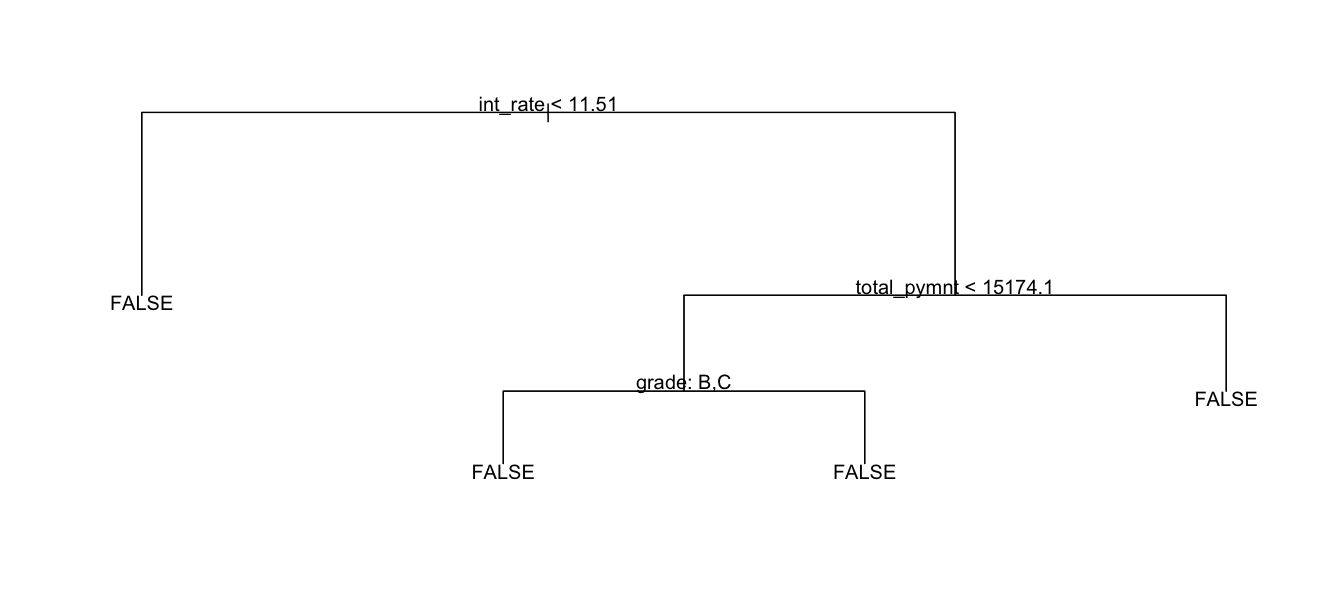

In [54]:
plot(tree.default)
text(tree.default, pretty = 0)

In [55]:
tree.default

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 40000 24730 FALSE ( 0.90712 0.09287 )  
   2) int_rate < 11.51 16476  5483 FALSE ( 0.96049 0.03951 ) *
   3) int_rate > 11.51 23524 18200 FALSE ( 0.86975 0.13025 )  
     6) total_pymnt < 15174.1 17643 15360 FALSE ( 0.84254 0.15746 )  
      12) grade: B,C 10901  7687 FALSE ( 0.88707 0.11293 ) *
      13) grade: D,E,F,G 6742  7263 FALSE ( 0.77054 0.22946 ) *
     7) total_pymnt > 15174.1 5881  2287 FALSE ( 0.95137 0.04863 ) *

In [56]:
tree.pred = predict(tree.default, df_sample[-train, ], type = "class")
with(df_sample[-train, ], table(tree.pred, Default))
# Accuracy 
(9383+287)/10000

         Default
tree.pred FALSE TRUE
    FALSE  9093  907
    TRUE      0    0

[1] 0.967

In [44]:
# This tree was grown to full depth, and might be too variable. We now use CV to prune it.
cv.default = cv.tree(tree.default, FUN = prune.misclass)
cv.default

$size
[1] 4 1

$dev
[1] 3629 3629

$k
[1] -Inf    0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

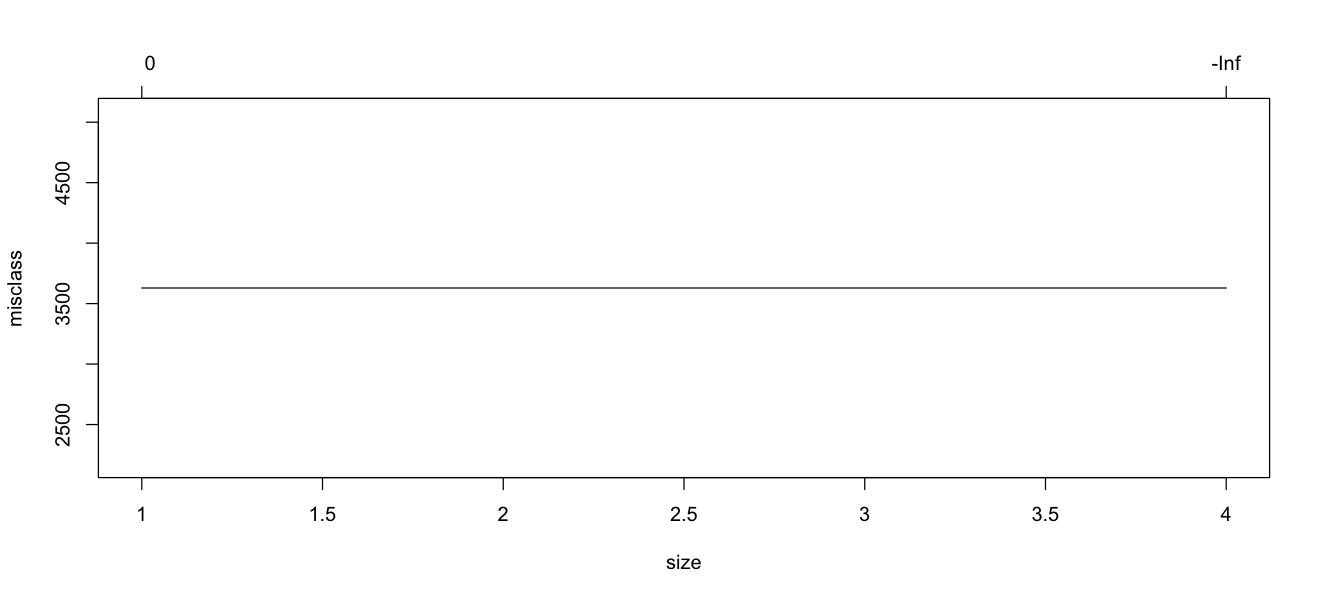

In [45]:
plot(cv.default)

In [57]:
prune.default = prune.misclass(tree.default, best = 4)
#plot(prune.default)
#text(prune.default, pretty = 0)

In [58]:
tree.pred = predict(prune.default, df_sample[-train, ], type = "class")
with(df_sample[-train, ], table(tree.pred, Default))

# Accuracy

         Default
tree.pred FALSE TRUE
    FALSE  9093  907
    TRUE      0    0

### 2. Random Forest
Lets fit a random forest and see how well it performs. We will use the response `Default`, whether the loan defaulted or charge off. 

In [59]:
table(df_sample$Default)


FALSE  TRUE 
45378  4622 

In [73]:
require(randomForest)

rf.default = randomForest(as.factor(Default) ~.,data = df_sample, subset=train)
rf.default


Call:
 randomForest(formula = as.factor(Default) ~ ., data = df_sample,      subset = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 9

        OOB estimate of  error rate: 9.11%
Confusion matrix:
      FALSE TRUE class.error
FALSE 36285    0   0.0000000
TRUE   3644   71   0.9808883

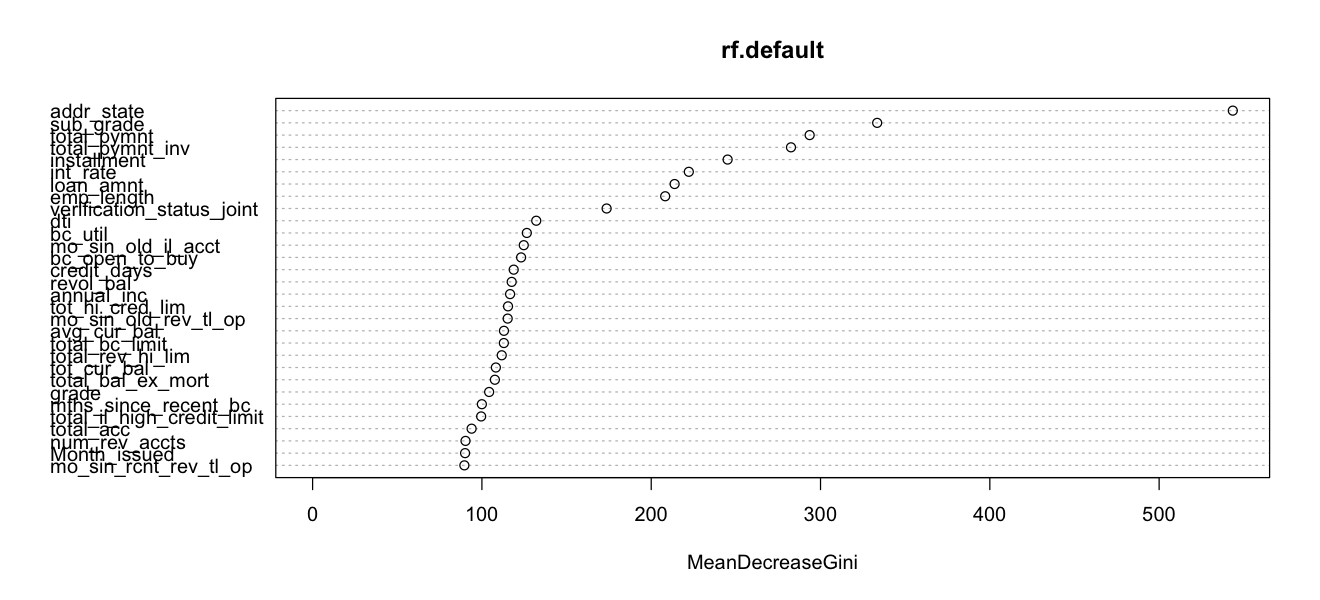

In [64]:
varImpPlot(rf.default)

In [74]:
importance(rf.default)

,MeanDecreaseGini
loan_amnt,215.88454001
term,25.89458743
int_rate,212.29097821
installment,241.84166355
grade,105.19103509
sub_grade,338.38637073
emp_length,208.27796403
home_ownership,21.43138972
annual_inc,116.86252157
verification_status,26.79706225


```R
k = 5
oob.err = double(k)
test.err = double(k)
for (mtry in 1:k) {
    fit = randomForest(as.factor(Default) ~ ., data = df_sample, subset = train, mtry = mtry, 
        ntree = 400)
    oob.err[mtry] = fit$mse[400]
    pred = predict(fit, df_sample[-train, ])
    test.err[mtry] = with(Boston[-train, ], mean((medv - pred)^2))
    cat(mtry, " ")
}

matplot(1:mtry, cbind(test.err, oob.err), pch = 19, col = c("red", "blue"), 
    type = "b", ylab = "Mean Squared Error")
legend("topright", legend = c("OOB", "Test"), pch = 19, col = c("red", "blue"))

```


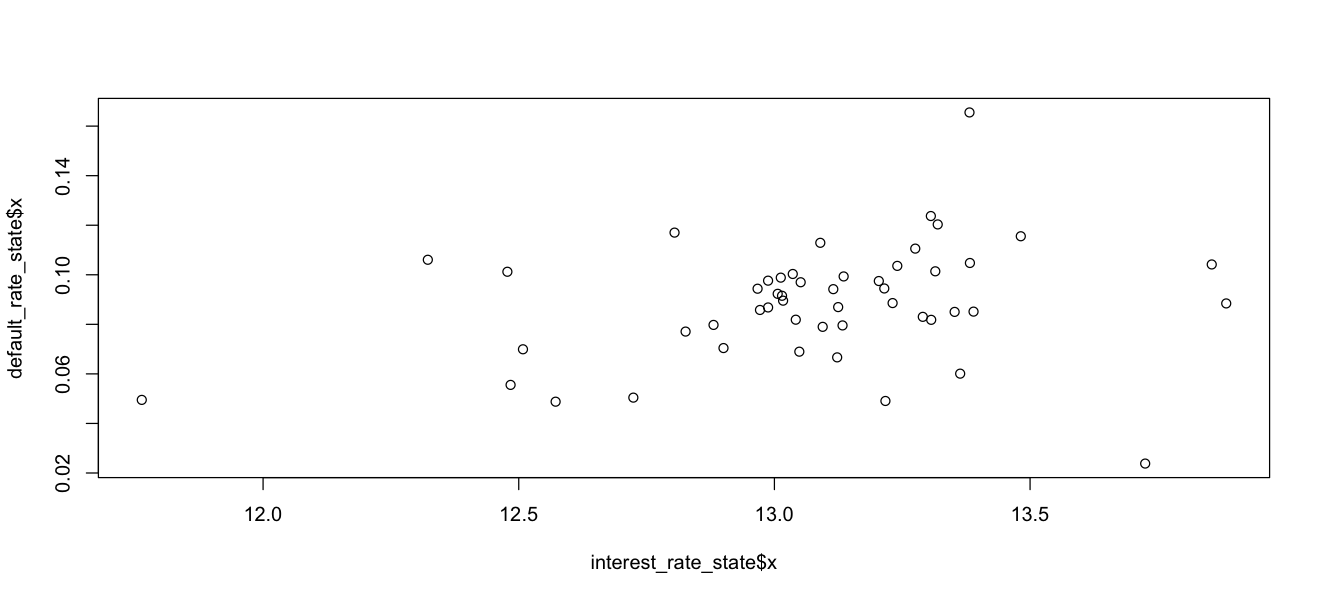

In [81]:
default_rate_state = aggregate(df_sample[, 'Default'], list(df_sample$addr_state), mean)
interest_rate_state = aggregate(df_sample[, 'int_rate'], list(df_sample$addr_state), mean)
plot( interest_rate_state$x, default_rate_state$x )

In [84]:
 cor(interest_rate_state$x, default_rate_state$x)

[1] 0.2585707

## II. Survival Models

Use right censored duration data so the following will create a survival object for the loan data. Note the ‘+’ after some entries, these are durations that have been marked as censored.

In [48]:
set.seed(1011)
# sample 50K rows:
sample_row = sample(1:nrow(df), 50000) 
df_surv = df[ sample_row,  !(names(df) %in% c(drop_list, drop_from_model,'desc' ))]
# set 40K rows to be training data:
train = sample(1:nrow(df_surv ),floor(nrow(df_sample)*0.8) )


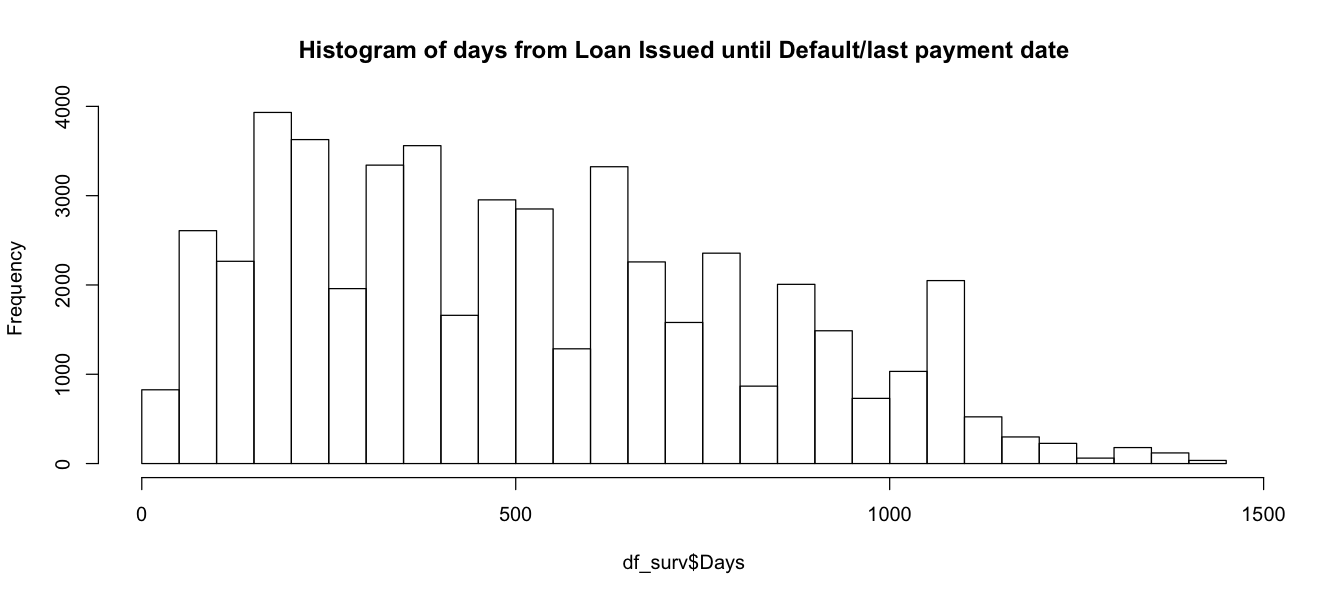

In [49]:
hist(df_surv$Days, breaks = 40, 
     main= 'Histogram of days from Loan Issued until Default/last payment date')

In [50]:
levels(df_surv$term)

[1] " 36 months" " 60 months"

Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:caret’:

    cluster



[1]  122+  975+ 1065+  548+  548   792+

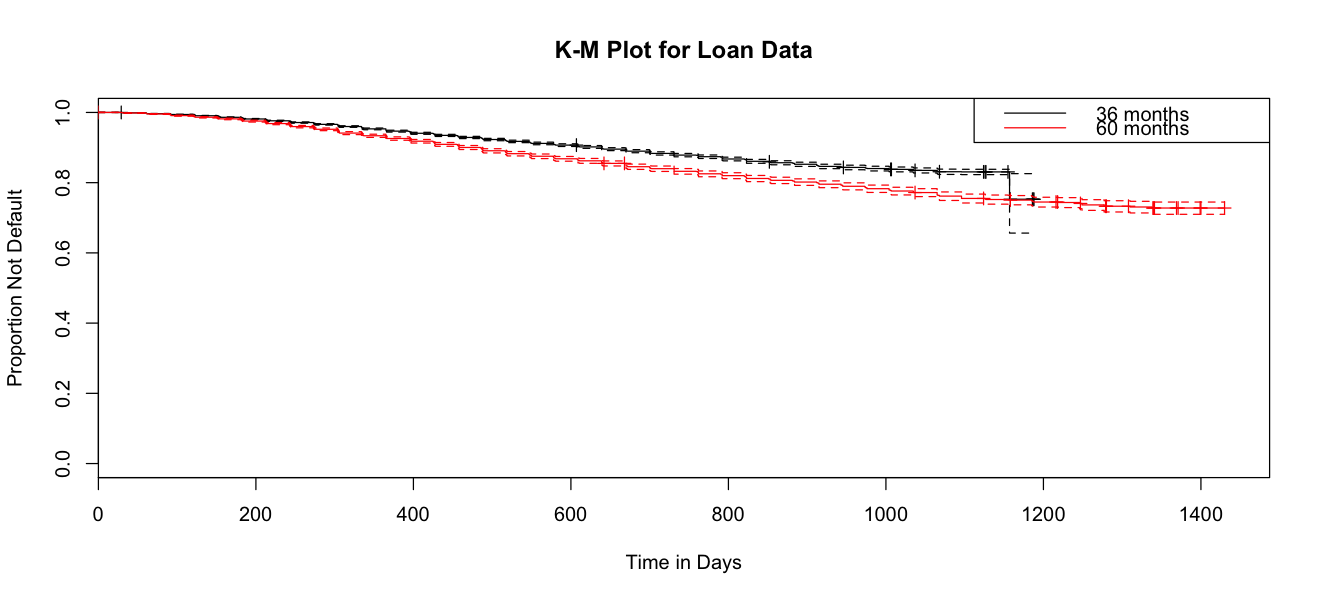

In [51]:
require(survival)
require(plyr)

### Create a survival object
survObj <- Surv(time= df_surv$Days, event= df_surv$Default==1, type='right')
head(survObj)

### Fit a Kaplan-Meier survival curve. 
km.by.term <- survfit(survObj ~ term, data = df_surv, conf.type = "log-log")

plot(km.by.term, conf.int=TRUE, mark.time=TRUE, 
     main="K-M Plot for Loan Data", xlab="Time in Days", ylab="Proportion Not Default", col=c(1:2))
legend('topright', c("36 months","60 months"), lty=1, col=c(1:2))

### Cox model

In [90]:
# help(coxph)
coxFit <- coxph(survObj ~ addr_state + term + sub_grade, data = df_surv)
summary(coxFit)

Call:
coxph(formula = survObj ~ addr_state + term + sub_grade, data = df_surv)

  n= 50000, number of events= 4622 

                   coef exp(coef) se(coef)      z Pr(>|z|)    
addr_stateAL    0.39466   1.48388  0.35586  1.109  0.26742    
addr_stateAR    0.45893   1.58238  0.36572  1.255  0.20952    
addr_stateAZ    0.40772   1.50339  0.34699  1.175  0.23998    
addr_stateCA    0.42488   1.52941  0.33612  1.264  0.20620    
addr_stateCO    0.25030   1.28441  0.35308  0.709  0.47839    
addr_stateCT    0.18981   1.20902  0.35612  0.533  0.59404    
addr_stateDC   -0.28803   0.74974  0.55815 -0.516  0.60583    
addr_stateDE    0.63200   1.88138  0.42776  1.477  0.13955    
addr_stateFL    0.33885   1.40333  0.33829  1.002  0.31652    
addr_stateGA    0.16287   1.17688  0.34493  0.472  0.63680    
addr_stateHI    0.34407   1.41067  0.38910  0.884  0.37655    
addr_stateID   -0.58467   0.55729  0.78228 -0.747  0.45483    
addr_stateIL    0.11440   1.12121  0.34309  0.333  0.73879    
a

### ridge：Ridge regression
- When used in a coxph or survreg model formula, specifies a ridge regression term. 
- The likelihood is penalised by theta/2 time the sum of squared coefficients. If scale=T the penalty is calculated for coefficients based on rescaling the predictors to have unit variance. 
- If df is specified then theta is chosen based on an approximate degrees of freedom.

In [86]:
coxRidge <- coxph(formula = survObj ~ ridge(., theta=1), data= df_surv )

summary(coxRidge)

ERROR: Error: is.atomic(x) is not TRUE


In [87]:
require('survival')
library('survivalROC') # https://cran.r-project.org/web/packages/survivalROC/survivalROC.pdf
library('randomForest') # https://cran.r-project.org/web/packages/randomForest/randomForest.pdf
library(repr)
# Change plot size 
options(repr.plot.width=6, repr.plot.height=5)
### 1. Random Survival Forest

Warning message:
“package ‘randomForestSRC’ was built under R version 3.4.2”
 randomForestSRC 2.5.1 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 



                         Sample size: 50000
                    Number of deaths: 4622
                     Number of trees: 100
           Forest terminal node size: 3
       Average no. of terminal nodes: 4770.86
No. of variables tried at each split: 10
              Total no. of variables: 82
                            Analysis: RSF
                              Family: surv
                      Splitting rule: logrank
                          Error rate: 12.64%



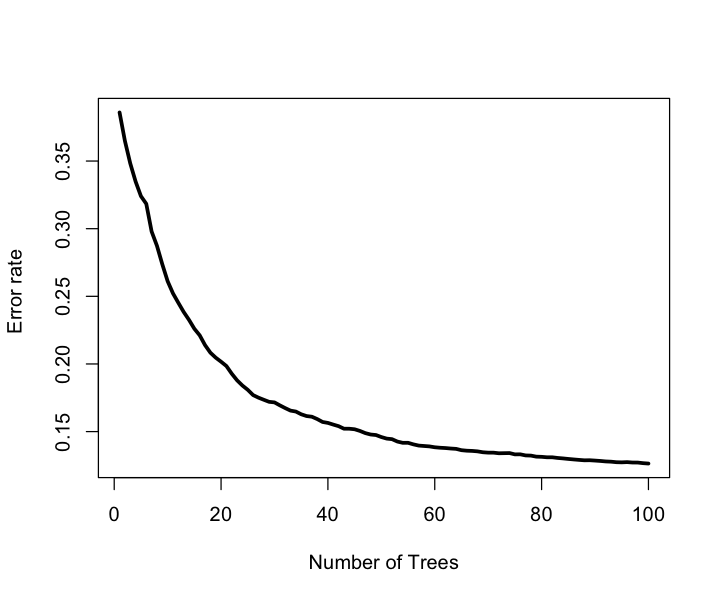

In [88]:
library(randomForestSRC)

v.obj <- rfsrc(Surv(Days, Default) ~ . , 
               data= df_surv, ntree = 100, tree.err=TRUE)

# print and plot the grow object
print(v.obj)
plot(v.obj)